In [1]:
import numpy as np
import torch

import sys
sys.path.append('../')
import mvpy as mv

In [61]:
X = np.random.normal(size = (50, 3, 60, 5))
X[:,0] += 1
X[:,1] += 0
X[:,2] += 1

rdm = mv.estimators.RSA(grouped = True, estimator = mv.math.cv_euclidean).transform(X)
p = rdm.mean(axis = 1)
p /= p.max()

mv.math.spearmanr(p, np.array([1, 0, 1]))

0.8660254037844387

In [39]:
p.shape, np.array([1, 0, 1, 0, 1]).shape

((10,), (5,))

In [16]:
%timeit rsa_np.transform(x_np)

6.81 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit rsa_tr.transform(x_tr)

5.24 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


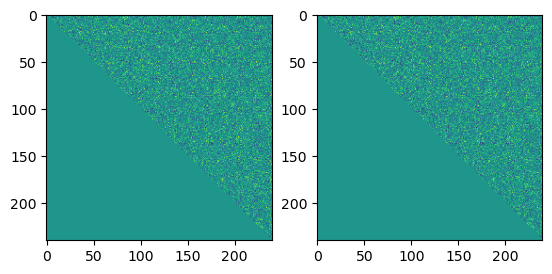

In [12]:
import matplotlib.pyplot as plt

rdm_np = np.zeros((240, 240, 500))
rdm_np[rsa_np.cx_,rsa_np.cy_] = r_np

rdm_tr = np.zeros((240, 240, 500))
rdm_tr[rsa_tr.cx_,rsa_tr.cy_] = r_tr

fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].imshow(rdm_np[...,0])
ax[1].imshow(rdm_tr[...,0])

In [7]:
np.allclose(r_np, r_tr)

True

In [9]:
X = torch.normal(0, 1, (10, 60, 5))

if True:
    if True:
        # setup dimensions
        dims = X.shape
        N, F, T = dims[0], dims[-2], dims[-1]
        
        # setup indices
        n = torch.arange(N)
        nx, ny = torch.meshgrid(n, n, indexing = 'ij')
        cx_, cy_ = torch.triu_indices(N, N, offset = 1)
        i, j = nx.T.flatten()[cx_], ny.flatten()[cy_]
        
        print(i, j)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8]) tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
        4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9])


(5, 2)


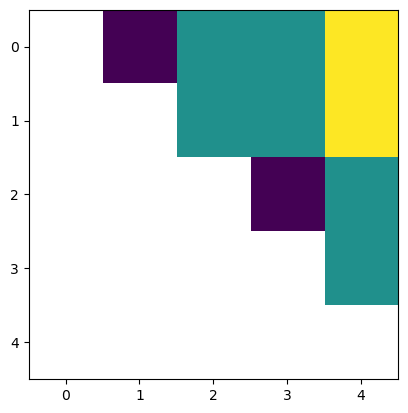

In [143]:
import sklearn
from typing import Any, Union, Callable
from joblib import Parallel, delayed

class _RSA_numpy(sklearn.base.BaseEstimator):
    '''
    '''
    
    def __init__(self, estimator: Callable = mv.math.euclidean, n_jobs: Union[int, None] = None):
        '''
        '''
        
        self.estimator_ = estimator
        self.n_jobs_ = n_jobs
        self.cx_ = None
        self.cy_ = None
        self.rdm_ = None

    def fit(self, *args):
        '''
        '''
        
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        '''
        '''
        
        # setup dimensions
        dims = X.shape
        
        # check dimensions
        if len(dims) < 2:
            raise ValueError('`X` must be at least 2-dimensional.')
        
        # check dimensions
        if len(dims) < 3:
            X = X[...,np.newaxis]
        
        # setup dimensions
        dims = X.shape
        N, F, T = dims[0], dims[-2], dims[-1]
        
        # setup indices
        n = np.arange(N)
        nx, ny = np.meshgrid(n, n)
        self.cx_, self.cy_ = np.triu_indices(N, k = 1)
        i, j = nx.flatten()[self.cx_], ny.T.flatten()[self.cy_]
        
        # compute RDM
        self.rdm_ = np.stack(Parallel(n_jobs = self.n_jobs_)
                                (delayed(self.estimator_)
                                    (X.swapaxes(-2, -1)[i,...,k,:], 
                                     X.swapaxes(-2, -1)[j,...,k,:])
                                 for k in range(T)),
                             axis = -1)
        


x = np.array([[0, 1], [0, 1], [0, 2], [0, 2], [0, 3]])
print(x.shape)
rsa = _RSA_numpy(estimator = mv.math.euclidean)
rsa.transform(x)

rdm = np.zeros((x.shape[0], x.shape[0])) * np.nan
rdm[rsa.cx_,rsa.cy_] = rsa.rdm_.squeeze()

import matplotlib.pyplot as plt
plt.imshow(rdm[:,:])

(190, 10)


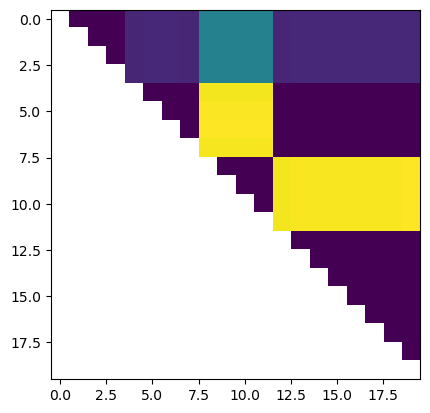

In [183]:
import sklearn
from typing import Any, Union, Callable
from joblib import Parallel, delayed

class _GroupedRSA_numpy(sklearn.base.BaseEstimator):
    '''
    '''
    
    def __init__(self, estimator: Callable = mv.math.euclidean, n_jobs: Union[int, None] = None):
        '''
        '''
        
        self.estimator_ = estimator
        self.n_jobs_ = n_jobs
        self.cx_ = None
        self.cy_ = None
        self.rdm_ = None

    def fit(self, *args):
        '''
        '''
        
        return self
    
    def transform(self, X: np.ndarray, *args: Any) -> np.ndarray:
        '''
        '''
        
        # setup dimensions
        dims = X.shape
        
        # check dimensions
        if len(dims) < 3:
            raise ValueError('`X` must be at least 3-dimensional.')
        
        # check dimensions
        if len(dims) < 4:
            X = X[...,np.newaxis]
        
        # setup dimensions
        dims = X.shape
        N, G, F, T = dims[0], dims[1], dims[-2], dims[-1]
        
        # setup indices
        n = np.arange(G)
        nx, ny = np.meshgrid(n, n)
        self.cx_, self.cy_ = np.triu_indices(G, k = 1)
        i, j = nx.flatten()[self.cx_], ny.T.flatten()[self.cy_]
        
        # compute RDM
        self.rdm_ = np.stack(Parallel(n_jobs = self.n_jobs_)
                                (delayed(self.estimator_)
                                    (X.swapaxes(-2, -1)[:,i,...,k,:].swapaxes(0, 1), 
                                     X.swapaxes(-2, -1)[:,j,...,k,:].swapaxes(0, 1),
                                     *args)
                                 for k in range(T)),
                             axis = -1)
        

x = np.random.normal(size = (10, 20, 60, 10))
x[:,0:4] = 5.0
x[:,8:12] = 15.0
lw = mv.estimators.Covariance().fit(x)

rsa = _GroupedRSA_numpy(estimator = mv.math.cv_mahalanobis)
rsa.transform(x, lw.covariance_)

rdm = np.zeros((x.shape[1], x.shape[1], 10)) * np.nan
rdm[rsa.cx_,rsa.cy_] = rsa.rdm_.squeeze()

print(rsa.rdm_.shape)

import matplotlib.pyplot as plt
plt.imshow(rdm[:,:,0])

-2

In [157]:
x.shape, mv.math.cv_euclidean(x, x).shape

((4, 5, 60, 10), (5, 60))

In [122]:
rsa.i_, rsa.j_

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]),
 array([0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

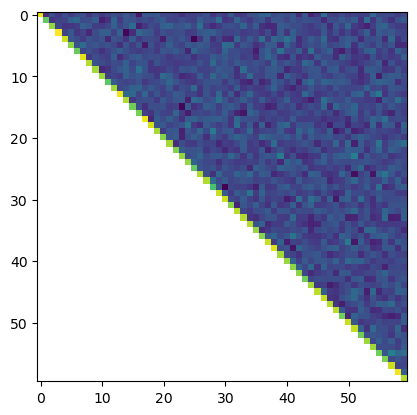

In [84]:
a = np.random.normal(size = (60, 60, 30)) + 10*np.eye(60)[...,None]
b = np.zeros((60, 60, 30)) * np.nan
x, y = np.triu_indices(60, k = 0)
b[x,y] = a[x,y]

plt.imshow(b[:,:,0])

In [67]:
rsa.cx_, rsa.cy_

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]),
 array([0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

In [56]:
import numpy as np

import numpy as np

class LedoitWolf2:
    def __init__(self):
        self.covariance_ = None
        self.shrinkage_ = None
    
    def fit(self, X):
        """Fit the Ledoit-Wolf shrinkage estimator to the data X."""
        n_samples, n_features = X.shape

        # Compute empirical covariance matrix (unbiased)
        X_centered = X - X.mean(axis=0)
        S = (X_centered.T @ X_centered) / (n_samples - 1)

        # Target: Scaled identity matrix (F)
        mu = np.trace(S) / n_features  # Mean of diagonal elements
        F = np.eye(n_features) * mu

        # Compute shrinkage numerator: Variance of S elements
        S_diag = np.diag(S)  # Diagonal elements of S
        off_diag_mask = ~np.eye(n_features, dtype=bool)  # Mask for off-diagonal elements
        S_off_diag = S[off_diag_mask]  # Extract off-diagonal elements

        var_diag = np.var(S_diag, ddof=1)  # Variance of diagonal elements
        var_off_diag = np.var(S_off_diag, ddof=1)  # Variance of off-diagonal elements

        shrinkage_numerator = var_diag + var_off_diag  # Total variance

        # Compute shrinkage denominator: Squared Frobenius norm
        frob_norm_sq = np.sum((S - F) ** 2)

        # Compute shrinkage coefficient
        rho = min(1, shrinkage_numerator / frob_norm_sq)

        # Compute Ledoit-Wolf covariance estimate
        self.covariance_ = rho * F + (1 - rho) * S
        self.shrinkage_ = rho  # Store shrinkage coefficient
        return self

    def get_covariance(self):
        """Return the estimated covariance matrix."""
        return self.covariance_

    def get_shrinkage(self):
        """Return the computed shrinkage coefficient."""
        return self.shrinkage_

class LedoitWolf3:
    def __init__(self):
        self.covariance_ = None
        self.shrinkage_ = None

    def fit(self, X):
        """
        Fit the Ledoit-Wolf shrinkage estimator to the data X.
        This implementation exactly follows scikit-learn's procedure.
        """
        
        X = np.asarray(X)
        n_samples, n_features = X.shape

        # Center the data
        Xc = X - np.mean(X, axis=0)

        # Compute the biased sample covariance matrix (dividing by n_samples)
        sample_cov = np.dot(Xc.T, Xc) / n_samples

        # Compute the target matrix F = mu * I,
        # where mu is the average of the eigenvalues (trace/sample dimension)
        mu = np.trace(sample_cov) / n_features
        F = mu * np.eye(n_features)

        # Compute phi: the sum of the elementwise variances
        # First, compute elementwise squared values of the centered data.
        X2 = Xc ** 2
        # Compute phi_mat as per Ledoit-Wolf:
        # (X2.T dot X2) / n_samples - sample_cov**2
        phi_mat = np.dot(X2.T, X2) / n_samples - sample_cov ** 2
        phi = np.sum(phi_mat)

        # Compute gamma: squared Frobenius norm of (sample_cov - F)
        gamma = np.linalg.norm(sample_cov - F, 'fro') ** 2

        # Compute kappa and then the shrinkage coefficient.
        kappa = phi / gamma if gamma != 0 else 0.0
        shrinkage = np.clip(kappa / n_samples, 0, 1)

        # Compute the shrunk covariance matrix
        self.covariance_ = shrinkage * F + (1 - shrinkage) * sample_cov
        self.shrinkage_ = shrinkage
        return self

    def get_covariance(self):
        """Return the estimated covariance matrix."""
        return self.covariance_

    def get_shrinkage(self):
        """Return the computed shrinkage coefficient."""
        return self.shrinkage_

real_cov = np.array([[.4, .2],
                     [.2, .8]])
X = np.random.multivariate_normal(mean=[0, 0],
                                  cov=real_cov,
                                  size=50)
from sklearn.covariance import LedoitWolf
cov_a = LedoitWolf2().fit(X)
cov_b = LedoitWolf().fit(X)
cov_c = LedoitWolf3().fit(X)

cov_a.covariance_, cov_b.covariance_, cov_c.covariance_

(array([[0.64108147, 0.03338183],
        [0.03338183, 0.75703101]]),
 array([[0.54986204, 0.07785559],
        [0.07785559, 0.82028819]]),
 array([[0.54986204, 0.07785559],
        [0.07785559, 0.82028819]]))

In [57]:
X.shape

(50, 2)

In [48]:
cov_b.shrinkage_, cov_a_shrinkage

(0.6846341850719838, 1)

In [9]:
x, y, z = 400, 60, 5

a = np.random.normal(size = (x, y, z))
b = np.random.normal(size = (x, y, z))

In [42]:
%timeit d = mv.math.euclidean(a, b)
%timeit d = mv.math.cosine(a, b)
%timeit d = mv.math.pearsonr(a, b)
%timeit d = mv.math.spearmanr(a, b)

923 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.99 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.48 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
233 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
device = 'cpu'

c, d = torch.from_numpy(a).to(torch.float32).to(device), torch.from_numpy(b).to(torch.float32).to(device)

In [44]:
%timeit r = mv.math.euclidean(c, d)
%timeit r = mv.math.cosine(c, d)
%timeit r = mv.math.pearsonr(c, d)
%timeit r = mv.math.spearmanr(c, d)

648 µs ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
519 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.69 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
196 ms ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
device = 'mps'

c, d = torch.from_numpy(a).to(torch.float32).to(device), torch.from_numpy(b).to(torch.float32).to(device)

In [46]:
%timeit r = mv.math.euclidean(c, d)
%timeit r = mv.math.cosine(c, d)
%timeit r = mv.math.pearsonr(c, d)
%timeit r = mv.math.spearmanr(c, d)

181 µs ± 700 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
207 µs ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
466 µs ± 7.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
65.2 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
import scipy

%timeit scipy.stats.rankdata(a, axis = -1)
%timeit mv.math.rank(a)
%timeit mv.math.rank(c)

239 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
123 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.5 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
indx_i = torch.from_numpy(np.arange(x).repeat(x)).to(torch.int32).to(device)
indx_j = torch.from_numpy(np.tile(np.arange(x), x)).to(torch.int32).to(device)

import time
ts = time.time()
rdm = mv.math.pearsonr(c[indx_i], c[indx_j])
te = time.time()

print(te - ts)

0.02225208282470703


In [60]:
t0 = np.arange(x)
t1 = np.arange(x)

tx, ty = np.meshgrid(t0, t1)
cx, cy = np.triu_indices(x, k = 1)
indc_i, indc_j = tx.flatten()[cx], ty.flatten()[cy]

#indc_i, indc_j = tx.flatten(), ty.flatten()
indc_i.shape, indc_j.shape

((19900,), (19900,))

In [63]:
import time

%timeit mv.math.pearsonr(c[indc_i], c[indc_j])

74.2 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
indc_i, indc_j

(array([  0,   1,   2, ..., 197, 198, 199]),
 array([  0,   0,   0, ..., 199, 199, 199]))

In [12]:
rdm.device

device(type='mps', index=0)

AttributeError: module 'mvpy.math' has no attribute 'cv_euclidean'

In [129]:
import sklearn

from typing import Union
from joblib import Parallel, delayed

class RSA(sklearn.base.BaseEstimator):
    def __init__(self, n_jobs: Union[int, None] = None):
        '''
        '''
        
        self.n_jobs = n_jobs
    
    def fit(self, X: torch.Tensor):
        '''
        '''
        
        return self
    
    def transform(self, X: torch.Tensor) -> torch.Tensor:
        '''
        '''
        
        # setup dimensions
        dims = X.shape
        N, F, T = dims[0], dims[-2], dims[-1]
        
        # setup indices
        n = torch.arange(N)
        nx, ny = torch.meshgrid(n, n, indexing = 'ij')
        cx, cy = torch.triu_indices(N, N, offset = 1)
        i, j = nx.flatten()[cx], ny.flatten()[cy]
        
        # compute RDM
        r = torch.stack(Parallel(n_jobs = self.n_jobs)(delayed(mv.math.euclidean)(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)), dim = -1)
        
    def fit_transform(self, X: torch.Tensor) -> torch.Tensor:
        '''
        '''
        
        return self.fit(X).transform(X)

In [25]:
X = c.clone()

if True:
    if True:
        # setup dimensions
        dims = X.shape
        N, F, T = dims[0], dims[-2], dims[-1]
        
        # setup indices
        n = torch.arange(N)
        nx, ny = torch.meshgrid(n, n, indexing = 'ij')
        cx, cy = torch.triu_indices(N, N, offset = 1)
        i, j = nx.flatten()[cx].to(torch.int32).to(c.device), ny.flatten()[cy].to(torch.int32).to(c.device)

In [26]:
f = mv.math.pearsonr

%timeit r = torch.stack([f(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)], dim = -1)

42.2 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
f = mv.math.pearsonr

%timeit r = torch.stack([f(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)], dim = -1)

31.6 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
r = torch.stack([f(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)], dim = -1)

In [16]:
r.shape, r.dtype, r.device

(torch.Size([79800, 500]), torch.float32, device(type='mps', index=0))

In [ ]:
%timeit r = mv.math.cosine(c.swapaxes(-2, -1)[i], c.swapaxes(-2, -1)[j])

In [158]:
n_jobs = 1

%timeit r = torch.stack(Parallel(n_jobs = n_jobs)(delayed(mv.math.euclidean)(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)), dim = -1)

579 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
n_jobs = 8

%timeit r = torch.stack(Parallel(n_jobs = n_jobs)(delayed(mv.math.euclidean)(c.swapaxes(-2, -1)[i,...,k,:], c.swapaxes(-2, -1)[j,...,k,:]) for k in range(T)), dim = -1)

6.73 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
RSA(n_jobs = None).fit_transform(c)

In [141]:
%timeit RSA(n_jobs = None).fit_transform(c)

484 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
%timeit RSA(n_jobs = 4).fit_transform(c)

6.7 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
c.swapaxes(-2, -1).shape

torch.Size([200, 10, 100])

In [71]:
n = torch.arange(N)
nx, ny = torch.meshgrid(n, n, indexing = 'ij')
cx, cy = torch.triu_indices(5, 5, offset = 1)
i, j = nx.flatten()[cx], ny.flatten()[cy]


tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]])

tensor([0, 0, 1, 1])

In [62]:
import matplotlib.pyplot as plt
plt.imshow(rdm.reshape((x, x, y))[:,:,0].cpu().numpy())

RuntimeError: shape '[200, 200, 50]' is invalid for input of size 995000